В этом блокноте я запускаю все эксперименты по сжатию модели (а результаты оцениваю в соседнем). 

Для запуска могут требоваться библиотеки, не указанные в requirements. 


In [1]:
original_path = 'C:/Users/ddale/Downloads/NLP/rusvectores/model.model'
exp_path = 'C:/Users/ddale/Downloads/NLP/compress_ft/'

In [2]:
import gensim
import numpy as np

import gc

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import sys

def add_sys_path(p):
    p = os.path.abspath(p)
    if p not in sys.path:
        sys.path.append(p)

In [4]:
add_sys_path('..')

In [5]:
from importlib import reload

import compress_fasttext
reload(compress_fasttext)

import compress_fasttext.utils
reload(compress_fasttext.utils)
from compress_fasttext.utils import getsize

import compress_fasttext.prune
reload(compress_fasttext.prune)
from compress_fasttext.prune import prune_ngrams


import compress_fasttext.navec_like
reload(compress_fasttext.navec_like)

import compress_fasttext.quantization
reload(compress_fasttext.quantization)
from compress_fasttext.quantization import quantize

import compress_fasttext.compress
reload(compress_fasttext.compress)
from compress_fasttext.compress import make_new_fasttext_model, quantize_ft, svd_ft, prune_ft, prune_ft_freq

In [19]:
from compress_fasttext.utils import mb
import compress_fasttext.evaluation
reload(compress_fasttext.evaluation)
from compress_fasttext.evaluation import make_evaluator

## Быстрый выигрыш: fp16 и удаление ненужных матриц

In [7]:
big_ft = gensim.models.fasttext.FastTextKeyedVectors.load(original_path)
big_ft.adjust_vectors()

In [8]:
print(mb(big_ft))

2723.8586988449097


In [21]:
ev = make_evaluator(big_ft, '../data/toy_corpora/')
print(ev(big_ft))

0.9999999998843826


Эксперимент первый: удаляем ненужную матрицу с векторами слов и сокращаем точность до полу-флоата.

На значениях векторов это не сказывается *примерно никак*, а модель худеет вдвое. 

In [38]:
ft_fp16 = make_new_fasttext_model(big_ft, big_ft.vectors.astype(np.float16), big_ft.vectors_ngrams.astype(np.float16))
print(mb(ft_fp16))

1280.6656951904297


In [39]:
original_size = mb(big_ft)
fp16_size = mb(ft_fp16)
fp16_sim = ev(ft_fp16)
print(fp16_sim)

0.9999999890477056


In [12]:
ft_fp16.save(exp_path + 'ft_fp16.bin')

In [234]:
ft_fp16_words = prune_ft(big_ft, new_vocab_size=len(big_ft.vocab), new_ngrams_size=1)
ft_fp16_words.vectors_ngrams = ft_fp16_words.vectors_ngrams * 0
print(mb(ft_fp16_words))
print(ev(ft_fp16_words))
ft_fp16_words.save(exp_path + 'ft_fp16_words.bin')

compressing vectors...
compressing ngrams...
136.25745010375977
0.348580438366339


In [235]:
top_vocab, top_vectors = prune_vocab(ft, new_vocab_size=0)
new_ngrams = big_ft.vectors_ngrams.astype(np.float16)

ft_fp16_ngrams = make_new_fasttext_model(
    big_ft,
    new_vectors=top_vectors,
    new_vectors_ngrams=new_ngrams,
    new_vocab=top_vocab,
)
print(mb(ft_fp16_ngrams))
print(ev(ft_fp16_ngrams))
ft_fp16_ngrams.save(exp_path + 'ft_fp16_ngrams.bin')

1144.410285949707
0.9878330512833536


## Сокращение размерности

По существу, тут используется старая добрая матричная декомпозиция (truncated SVD). 

Широкая матрица из дробных чисел приближенно представляется как произведение двух узких. 

In [27]:
dimred_sizes = []
dimred_sims = []
dimred_dims = [150, 100, 50, 25, 10, 5]

for d in dimred_dims:
    model = svd_ft(big_ft, n_components=d)
    s = mb(model)
    q = vecs_similarity(big_ft, model)
    dimred_sizes.append(s)
    dimred_sims.append(q)
    print(d, s, q)
    model.save(exp_path + 'ft_dimred_{}.bin'.format(d))
    gc.collect()

compressing vectors...
compressing ngrams...
150 661.2565078735352 0.8674464881926655
compressing vectors...
compressing ngrams...
100 454.7863998413086 0.8048919371409442
compressing vectors...
compressing ngrams...
50 248.31629180908203 0.7048132591296397
compressing vectors...
compressing ngrams...
25 145.08123779296875 0.6159112646286635
compressing vectors...
compressing ngrams...
10 83.14020538330078 0.5091043212734655
compressing vectors...
compressing ngrams...
5 62.493194580078125 0.4110239894409791


In [30]:
gc.collect()

0

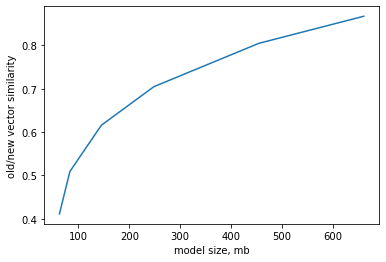

In [34]:
plt.plot(dimred_sizes, dimred_sims);
plt.xlabel('model size, mb');
plt.ylabel('old/new vector similarity');

## Квантизация

В базовом варианте квантизация - это следующий логичный шаг после перехода от float32 к float16. Теперь мы заменим float'ы в матрице эмбеддингов на int'ы! Но использоваться они будут только для хранения, а при применении эмбеддинга каждому int'у будет сопоставляться дробное число, взятое из специальной матрицы-справочника. Получить такой справочник можно с помощью кластеризации (типа k-means). 

Идея о кластеризации может навести на следующий шаг: а давайте сопоставим int'ы не отдельным числам-компонентам эмбеддинга, а их последовательностям. Например, если кодироваться будут последовательности из 3 чисел, то 300-мерный вектор можно будет приближенно описать 100 целочисленными кодами. Такой подход называется product quantization, и он позволяет подойти к задаче сокращения размерности с совершенно иной стороны, чем матричная декомпозиция. 



```
300 976.6052942276001 0.9934673549560236
150 518.0685205459595 0.9764971832428561
100 365.2229471206665 0.949259066389255
50 212.37737369537354 0.85697155924806
25 135.95458698272705 0.7258812834258547
10 90.10091495513916 0.5838264818986315
5 74.81635761260986 0.5129448006057942
```

In [62]:
pq_sizes = []
pq_sims = []
pq_dims = [300, 150, 100, 50, 25, 10, 5]

for d in pq_dims:
    model = quantize_ft(big_ft, qdim=d, centroids=255, sample=10_000)
    s = mb(model)
    q = vecs_similarity(big_ft, model)
    pq_sizes.append(s)
    pq_sims.append(q)
    print(d, s, q)
    model.save(exp_path + 'ft_pq_{}.bin'.format(d))
    gc.collect()

quantizing vectors...


c:\users\ddale\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


quantizing ngrams...
300 662.4258499145508 0.993575371569805
quantizing vectors...


c:\users\ddale\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


quantizing ngrams...
150 352.7195167541504 0.9757201153163947
quantizing vectors...


c:\users\ddale\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


quantizing ngrams...
100 249.48408126831055 0.9477202867444653
quantizing vectors...


c:\users\ddale\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


quantizing ngrams...
50 146.2486457824707 0.8563988019639737
quantizing vectors...


c:\users\ddale\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


quantizing ngrams...
25 94.63092803955078 0.725524188447976
quantizing vectors...


c:\users\ddale\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


quantizing ngrams...
10 63.66029739379883 0.5848841974721042
quantizing vectors...


c:\users\ddale\appdata\local\programs\python\python36\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


quantizing ngrams...
5 53.336753845214844 0.5187669587603937


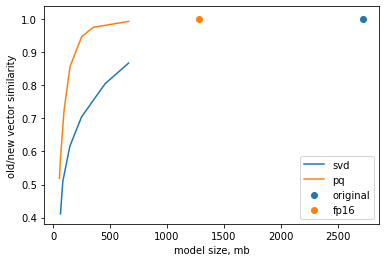

In [64]:
plt.plot(dimred_sizes, dimred_sims)
plt.plot(pq_sizes, pq_sims)
plt.scatter([original_size], [1])
plt.scatter([fp16_size], [fp16_sim])
plt.legend(['svd', 'pq', 'original', 'fp16'])

#plt.xscale('log')
plt.xlabel('model size, mb')
plt.ylabel('old/new vector similarity');

## Уменьшение словаря

Мы уже попробовали уменьшить матрицы fasttext-модели в ширину (с помощью декомпозиции) и "в глубину" (округляя их значения). Но ведь можно уменьшать матрицы и в длину, просто избавляясь от некоторых строк! Fasttext позволяет делать это относительно безнаказанно, ведь представление незнакомого слова можно построить по его n-граммам, а к самим n-граммам применен hashing trick. 

In [48]:
n_vecs = big_ft.vectors.shape[0]
n_grams = big_ft.vectors_ngrams.shape[0]
print(n_vecs, n_grams)

164996 2000000


Честно говоря, тут творится какая-то самая магическая магия, потому что теперь качество модели и размер связаны совсем немонотонно - они зависят от числа коллизий, а оно зависит от размера хэшей...

При сжатии модели с коэффициентом 1.0 я получаю тот же самый размер модели, но совершенно ужасную точность.

ПОЧЕМУ???

In [15]:
trim_sizes = []
trim_sims = []
trim_mults = [1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

for d in trim_mults:
    model = trim_ft(big_ft, new_ngrams_size=int(d*n_grams), new_vocab_size=int(d*n_vecs), fp16=True)
    s = mb(model)
    q = vecs_similarity(big_ft, model)
    trim_sizes.append(s)
    trim_sims.append(q)
    print('{:6.6}  {:6.6}  {:6.4}'.format(d, s, q))
    model.save(exp_path + 'ft_trim_{}.bin'.format(d))
    gc.collect()

compressing vectors...
compressing ngrams...



   1.0  1280.67  0.9126
compressing vectors...
compressing ngrams...



   0.5  640.818  0.9195
compressing vectors...
compressing ngrams...



   0.2  257.071  0.9026
compressing vectors...
compressing ngrams...



   0.1  128.473  0.8933
compressing vectors...
compressing ngrams...



  0.05  64.2367  0.8442
compressing vectors...
compressing ngrams...



  0.02  25.7229  0.7655
compressing vectors...
compressing ngrams...



  0.01  12.8615  0.6882
compressing vectors...
compressing ngrams...



 0.005  6.43079  0.6139
compressing vectors...
compressing ngrams...



 0.002  2.5671  0.5112
compressing vectors...
compressing ngrams...



 0.001  1.2836  0.4416


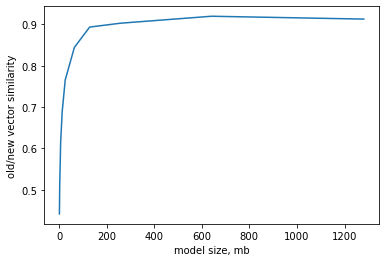

In [16]:
plt.plot(trim_sizes, trim_sims);
plt.xlabel('model size, mb');
plt.ylabel('old/new vector similarity');

# Отбор n-грам

In [50]:
big_n = big_ft.vectors_ngrams.shape[0]
small_n = 10_000 

new_to_old_buckets, old_hash_count = compress_fasttext.prune.count_buckets(
    big_ft, list(big_ft.vocab.keys()) , small_n
)
print(big_n)
print(len(old_hash_count))

2000000
331328


In [53]:
trimf_sizes = []
trimf_sims = []
trimf_mults = [1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

for d in trimf_mults:
    model = prune_ft_freq(big_ft, new_ngrams_size=int(d*len(old_hash_count)), new_vocab_size=int(d*n_vecs), fp16=True, pq=False)
    s = mb(model)
    q = ev(model)
    trimf_sizes.append(s)
    trimf_sims.append(q)
    print('{:6.6}  {:6.6}  {:6.4}'.format(d, s, q))
    model.save(exp_path + 'ft_prune_freq_{}.bin'.format(d))
    gc.collect()

   1.0  447.942  0.9997
   0.5  224.452  0.9979
   0.2  91.0208  0.9848
   0.1  45.4441  0.9504
  0.05  22.656  0.8855
  0.02  9.1423  0.7675
  0.01  4.56761  0.6627
 0.005  2.27995  0.5778
 0.002  0.891689  0.4594
 0.001  0.444801  0.3591


# Разбираемся в странностях сжатия

Одной странностью была бага, которую я посадил при пересортировке словаря. 

Другая странность - что однобуквенные слова в словарь обученной модели не входят, и оттого совершенно теряются. 


In [10]:
ft = big_ft

In [11]:
gc.collect()
model = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_trim_{}.bin'.format(1.0))

In [25]:
from compress_fasttext.evaluation import cosine, vocabulary_from_files

In [26]:
tv = vocabulary_from_files('../data/toy_corpora/')

In [41]:
len(tv)

1268

In [29]:
lost = set()
for w in tv:
    c = cosine(ft[w], model[w])
    if c < 0.95 and w not in lost:
        lost.add(w)
        print('{:20} {:+4.4} '.format(w, c))

сетях                +0.8934 
случае               +0.9344 
службы               +0.9065 
ноября               +0.9356 


Из 2 миллионов строк используются, кажется, только 330 тысяч. Вот это расточительность!

In [12]:
big_n = big_ft.vectors_ngrams.shape[0]
small_n = 10_000 

new_to_old_buckets, old_hash_count = compress_fasttext.prune.count_buckets(
    big_ft, list(big_ft.vocab.keys()) + ['и', 'а', 'у', 'в'], small_n
)
print(big_n)
print(len(old_hash_count))

2000000
331332


In [17]:
import pandas as pd

In [18]:
cvs = pd.Series(list(old_hash_count.values())).sort_values(ascending=False)

In [19]:
cvs.quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50      2.0
0.75      5.0
0.90     16.0
0.95     33.0
0.99    156.0
dtype: float64

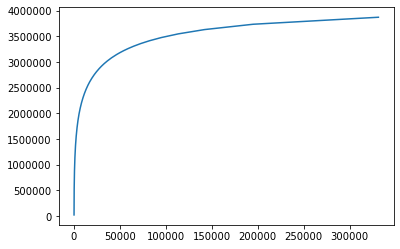

In [20]:
plt.plot(cvs.values.cumsum());

# Гибридная моделька

In [29]:
ft_prune_01 = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_trim_{}.bin'.format(0.1))
print(mb(ft_prune_01))
print(vecs_similarity(big_ft, ft_prune_01))

128.47385025024414
0.8932943583602944


In [59]:
ft_prune_01_pq_100 = quantize_ft(ft_prune_01, qdim=100, centroids=255, sample=None)
print(mb(ft_prune_01_pq_100))
print(vecs_similarity(big_ft, ft_prune_01_pq_100))

quantizing vectors...
quantizing ngrams...
26.406986236572266
0.8689667435098675


In [63]:
ft_prune_01_pq_100.save(exp_path + 'ft_prune_0.1_pq_100.bin')

In [72]:
ft_prune_05 = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_trim_{}.bin'.format(0.5))
print(mb(ft_prune_05))
print(vecs_similarity(big_ft, ft_prune_05))

ft_prune_05_pq_100 = quantize_ft(ft_prune_05, qdim=100, centroids=255, sample=None)
print(mb(ft_prune_05_pq_100))
print(vecs_similarity(big_ft, ft_prune_05_pq_100))

640.8182830810547
0.9194673153986586
quantizing vectors...
quantizing ngrams...
125.81085586547852
0.8785711846324927


In [73]:
ft_prune_05_pq_100.save(exp_path + 'ft_prune_0.5_pq_100.bin')

In [ ]:
ftc2 = prune_ft_freq(big_ft, new_vocab_size=20_000, new_ngrams_size=100_000, pq=True, qdim=100)
print(mb(ftc2))
print(ev(ftc2))

In [ ]:
ftc2.save(exp_path + 'ft_freqprune_100K_20K_pq_100.bin')

### Подбор параметров

Делаем целый парад гибридных моделек (это можно было бы на самом деле заметно ускорить, копируя словарики, но чё-то мне лень).

4 * 3 * 4 = 48 моделек придётся сейчас положить мне на диск. Но ладно. 

In [225]:
from compress_fasttext.prune import prune_ngrams, prune_vocab, count_buckets, RowSparseMatrix

In [228]:
def prune_ft_freq(ft, new_vocab_size=20_000, new_ngrams_size=100_000, fp16=True, pq=True, qdim=100, centroids=255):
    new_to_old_buckets, old_hash_count = count_buckets(ft, list(ft.vocab.keys()), new_ngrams_size=new_ngrams_size)
    id_and_count = sorted(old_hash_count.items(), key=lambda x: x[1], reverse=True)
    ids = [x[0] for x in id_and_count[:new_ngrams_size]]
    top_ngram_vecs = ft.vectors_ngrams[ids]
    if pq and len(top_ngram_vecs) > 0:
        top_ngram_vecs = quantize(top_ngram_vecs, qdim=qdim, centroids=centroids)
    elif fp16:
        top_ngram_vecs = top_ngram_vecs.astype(np.float16)
    rsm = RowSparseMatrix.from_small(ids, top_ngram_vecs, nrows=ft.vectors_ngrams.shape[0])

    top_voc, top_vec = prune_vocab(ft, new_vocab_size=new_vocab_size)
    if pq and len(top_vec) > 0:
        top_vec = quantize(top_vec, qdim=qdim, centroids=centroids)
    elif fp16:
        top_vec = top_vec.astype(np.float16)

    return make_new_fasttext_model(ft, top_vec, rsm, new_vocab=top_voc)


In [236]:
for qdim in [300, 100, 50]:
    for new_ngrams_size in [400_000, 100_000, 50_000]:
        for new_vocab_size in [100_000, 20_000, 5_000, 0]:
            mn = 'ft_freqprune_{}K_{}K_pq_{}.bin'.format(int(new_ngrams_size/1000), int(new_vocab_size/1000), qdim)
            print(mn)
            if os.path.exists(exp_path + mn):
                continue
            ftc = prune_ft_freq(big_ft, new_vocab_size=new_vocab_size, new_ngrams_size=new_ngrams_size, pq=True, qdim=qdim)
            ftc.save(exp_path + mn)

ft_freqprune_400K_100K_pq_300.bin
ft_freqprune_400K_20K_pq_300.bin
ft_freqprune_400K_5K_pq_300.bin
ft_freqprune_400K_0K_pq_300.bin
ft_freqprune_100K_100K_pq_300.bin
ft_freqprune_100K_20K_pq_300.bin
ft_freqprune_100K_5K_pq_300.bin
ft_freqprune_100K_0K_pq_300.bin
ft_freqprune_50K_100K_pq_300.bin
ft_freqprune_50K_20K_pq_300.bin
ft_freqprune_50K_5K_pq_300.bin
ft_freqprune_50K_0K_pq_300.bin
ft_freqprune_400K_100K_pq_100.bin
ft_freqprune_400K_20K_pq_100.bin
ft_freqprune_400K_5K_pq_100.bin
ft_freqprune_400K_0K_pq_100.bin
ft_freqprune_100K_100K_pq_100.bin
ft_freqprune_100K_20K_pq_100.bin
ft_freqprune_100K_5K_pq_100.bin
ft_freqprune_100K_0K_pq_100.bin
ft_freqprune_50K_100K_pq_100.bin
ft_freqprune_50K_20K_pq_100.bin
ft_freqprune_50K_5K_pq_100.bin
ft_freqprune_50K_0K_pq_100.bin
ft_freqprune_400K_100K_pq_50.bin
ft_freqprune_400K_20K_pq_50.bin
ft_freqprune_400K_5K_pq_50.bin
ft_freqprune_400K_0K_pq_50.bin
ft_freqprune_100K_100K_pq_50.bin
ft_freqprune_100K_20K_pq_50.bin
ft_freqprune_100K_5K_pq_50.bin

## считываем результаты с диска и сравниваем

Перенёс этот раздел в evaluate_all.ipynb

In [42]:
ft_prune_01_pq_100 = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_prune_0.1_pq_100.bin')

In [43]:
ft_freqprune_100K_20K_pq_100 = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_freqprune_100K_20K_pq_100.bin')

In [31]:
format3 = '{:6.6}  {:6.6}  {:6.4}'

In [33]:
dimred_sizes = []
dimred_sims = []
dimred_dims = [150, 100, 50, 25, 10, 5]

for d in dimred_dims:
    model = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_dimred_{}.bin'.format(d))
    s = mb(model)
    q = ev(model)
    dimred_sizes.append(s)
    dimred_sims.append(q)
    print(format3.format(d*1.0, s, q))
    gc.collect()

 150.0   661.6  0.8857
 100.0  455.015  0.8281
  50.0  248.431  0.7412
  25.0  145.139  0.6612
  10.0  83.1632  0.5557
   5.0  62.5048  0.4646


In [ ]:
300 976.6052942276001 0.9934673549560236
150 518.0685205459595 0.9764971832428561
100 365.2229471206665 0.949259066389255
50 212.37737369537354 0.85697155924806
25 135.95458698272705 0.7258812834258547
10 90.10091495513916 0.5838264818986315
5 74.81635761260986 0.5129448006057942

In [35]:
pq_sizes = []
pq_sims = []
pq_dims = [300, 150, 100, 50, 25, 10, 5]

for d in pq_dims:
    model = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_pq_{}.bin'.format(d))
    s = mb(model)
    q = ev(model)
    pq_sizes.append(s)
    pq_sims.append(q)
    print(format3.format(d*1.0, s, q))
    gc.collect()

 300.0  662.427  0.9909
 150.0  352.72  0.9686
 100.0  249.485  0.9377
  50.0  146.25  0.8424
  25.0  94.6319  0.7234
  10.0  63.6613   0.607
   5.0  53.3377  0.5468


```
исходно было вообще что-то бешеное

1.0 1280.6667785644531 0.7343834324890214
0.5 640.8182830810547 0.7475458227979501
0.2 257.0719566345215 0.7804176247791937
0.1 128.47385025024414 0.7923524743459548
0.05 64.23728561401367 0.8217848257624584
0.02 25.72348403930664 0.7655165270039631
0.01 12.862011909484863 0.6882214727696405
0.005 6.431332588195801 0.6139219773191233
0.002 2.5676469802856445 0.5112279759786497
0.001 1.2841386795043945 0.4415964335883225
```

In [36]:
trim_sizes = []
trim_sims = []
trim_mults = [1.0, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001]

for d in trim_mults:
    model = gensim.models.fasttext.FastTextKeyedVectors.load(exp_path + 'ft_trim_{}.bin'.format(d))
    s = mb(model)
    q = ev(model)
    trim_sizes.append(s)
    trim_sims.append(q)
    print(format3.format(d, s, q))
    gc.collect()

   1.0  1280.67  0.9997
   0.5  640.818  0.9956
   0.2  257.072  0.9833
   0.1  128.474  0.9628
  0.05  64.2373  0.9237
  0.02  25.7235  0.8444
  0.01  12.862  0.7608
 0.005  6.43133  0.6725
 0.002  2.56765  0.5694
 0.001  1.28414  0.5004


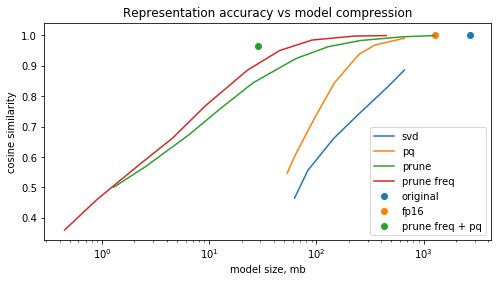

In [63]:
plt.figure(figsize=(8,4))

plt.plot(dimred_sizes, dimred_sims)
plt.plot(pq_sizes, pq_sims)
plt.plot(trim_sizes, trim_sims)
plt.plot(trimf_sizes, trimf_sims)

plt.scatter([original_size], [1])
plt.scatter([fp16_size], [fp16_sim])

# plt.scatter([mb(ft_prune_01_pq_100),], [ev(ft_prune_01_pq_100),])

plt.scatter(
    [mb(ft_freqprune_100K_20K_pq_100)], 
    [ev(ft_freqprune_100K_20K_pq_100)]
)
plt.legend(['svd', 'pq', 'prune', 'prune freq', 'original', 'fp16', 'prune freq + pq'], loc='lower right')

plt.xscale('log')
plt.xlabel('model size, mb')
plt.ylabel('cosine similarity')
plt.title('Representation accuracy vs model compression');